In [1]:
import sys
sys.path.append('/home/idnm/Programming projects/jax_circuits/')

from jax_circuits import *
from qiskit import transpile
from qiskit.circuit.library import *
from qiskit.quantum_info import OneQubitEulerDecomposer, random_clifford
from cp_utils import *
from scipy.stats import unitary_group

plt.rcParams.update({'font.size': 14})

To do

1. Local minima plots in an accurate way:
    1. For each ansatz several random unitaries and several self-unitaries. 
    1. Separately stats for different realizations of Toffoli 3 and Toffoli 4 gates.

# Local minimums

## Empirical success ratio: definition and example

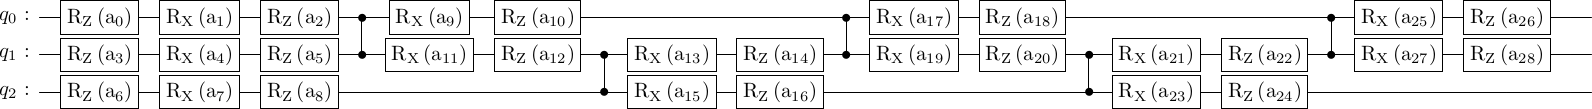

In [90]:
anz = Ansatz(3, 'cz', fill_layers(chain_layer(3), 5))
target_angles = random_angles(anz.num_angles)
target_circuit = anz.circuit(target_angles)
target_unitary = anz.unitary(target_angles)

anz.circuit().draw(output='latex')

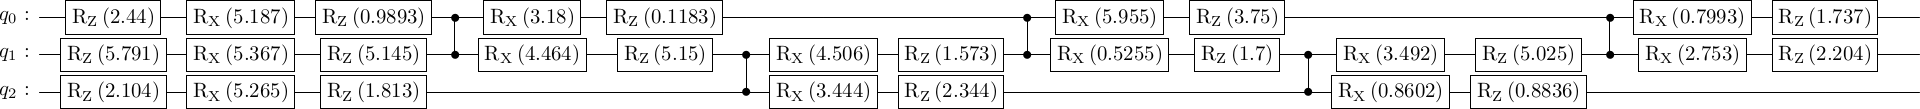

In [92]:
target_circuit.draw(output='latex')

Success ratio of out default optimization procedure is found as follows.

In [93]:
results = anz.learn(
    target_unitary, 
    method='adam',
    learning_rate=0.1,
    num_iterations=5000,
    num_repeats=100)

success_record = [jnp.min(r['loss'])<1e-4 for r in results]
sr = sum(success_record)/len(success_record)
print(f'Success Ratio is {sr}')

Success Ratio is 0.38999998569488525


## 3q chart

In [3]:
def mean_and_std(results):
    mean_list = []
    std_list = []
    for i in range(len(results[0])):
        sr_list = jnp.array([res[i]['success_ratio'] for res in results])
        mean_list.append(jnp.mean(sr_list))
        std_list.append(jnp.std(sr_list))
    
    return mean_list, std_list        

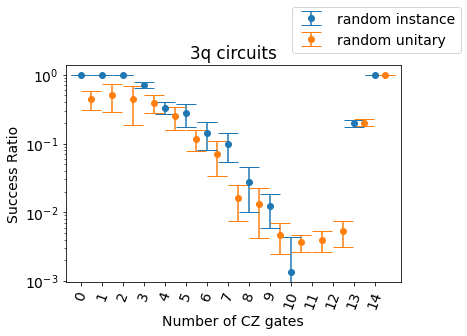

In [87]:
results_self = []
for i in range(10):
    with open(f'data/local_minimums/3q_random_self_rs{i}', 'rb')  as f:
        results_self.append(pickle.load(f))
        
results_unitary = []
for i in range(10):
    with open(f'data/local_minimums/3q_random_unitary_rs{i}', 'rb')  as f:
        results_unitary.append(pickle.load(f))        
        
mean_list_self, std_list_self = mean_and_std(results_self)
mean_list_unitary, std_list_unitary = mean_and_std(results_unitary)
plt.errorbar(range(len(mean_list_self)), mean_list_self, yerr=std_list_self, fmt='o', capsize=10, label='random instance')
plt.errorbar(jnp.arange(len(mean_list_unitary))+0.5, mean_list_unitary, yerr=std_list_unitary, fmt='o', capsize=10, label='random unitary')
plt.legend(bbox_to_anchor=(1.2, 1.3))

plt.yscale('log')
plt.xticks(range(len(mean_list_unitary)), rotation=70)
plt.ylabel('Success Ratio')
plt.xlabel('Number of CZ gates')
plt.title('3q circuits')
plt.savefig('figures/3q_success_chart', dpi=1000, bbox_inches='tight')

## 4q chart

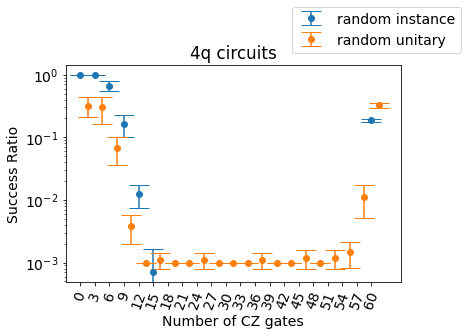

In [89]:
results_self = []
for i in range(10):
    with open(f'data/local_minimums/4q_random_self_rs{i}', 'rb')  as f:
        results_self.append(pickle.load(f))
        
results_unitary = []
for i in range(10):
    with open(f'data/local_minimums/4q_random_unitary_rs{i}', 'rb')  as f:
        results_unitary.append(pickle.load(f))        
        
mean_list_self, std_list_self = mean_and_std(results_self)
mean_list_unitary, std_list_unitary = mean_and_std(results_unitary)

xticks = jnp.arange(theoretical_lower_bound(4)+1)[::3]
plt.errorbar(xticks, mean_list_self, yerr=std_list_self, fmt='o', capsize=10, label='random instance')
plt.errorbar(xticks+1.5, mean_list_unitary, yerr=std_list_unitary, fmt='o', capsize=10, label='random unitary')
plt.legend(bbox_to_anchor=(1.2, 1.3))

plt.xlim([-3, 66])
plt.yscale('log')
plt.xticks(xticks, rotation=70)
plt.ylabel('Success Ratio')
plt.xlabel('Number of CZ gates')
plt.title('4q circuits')
plt.savefig('figures/4q_success_chart', dpi=1000, bbox_inches='tight')        

# CPFlow

## Main ideas

$CP$-templates.

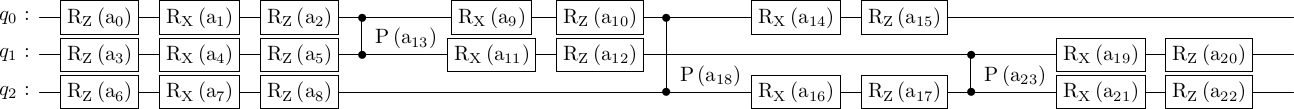

In [100]:
anz = Ansatz(3, 'cp', fill_layers(connected_layer(3),3))
anz.circuit().draw(output='latex')

Regularization function.

In [131]:
RegularizationOptions()

RegularizationOptions(function='linear', ymax=2, xmax=1.5707963267948966, plato_0=0.05, plato_1=0.05, plato_2=0.05)

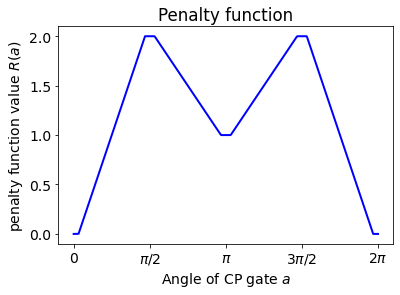

In [135]:
regularization_options = RegularizationOptions(plato_0=0.1, plato_1=0.1, plato_2=0.1)
regularization_func = make_regularization_function(regularization_options)
a_sweep = jnp.linspace(0, 2*jnp.pi, 500)

plt.plot(a_sweep, vmap(regularization_func)(a_sweep), 'blue', linewidth=2)
plt.xticks([0, jnp.pi/2, jnp.pi, 3*jnp.pi/2, 2*jnp.pi], ['$0$', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$'])
plt.title('Penalty function')
plt.ylabel('penalty function value $R(a)$')
plt.xlabel('Angle of CP gate $a$')
plt.savefig('figures/penalty', dpi=1000, bbox_inches='tight')        

# Toffoli

## Toffoli 3

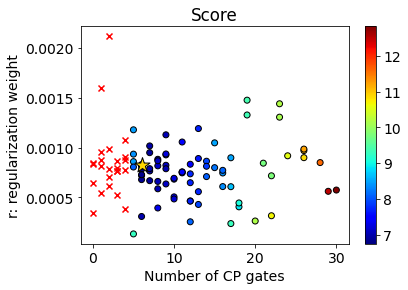

In [2]:
results = Results.load('data/toff3_conn')
results.plot_trials()

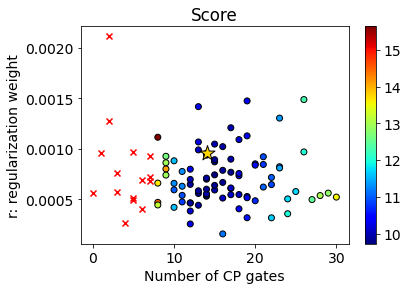

In [3]:
results = Results.load('data/toff3_chain')
results.plot_trials()